# **Project - Part 2: Indexing and Evaluation**
## **Indexing**
1. **Build inverted index:** After having pre-processed the data, you can then create the inverted index.
>**HINT** - you may use the vocabulary data structure, like the one seen during the Practical Labs:
>>{
Term_id_1: [document_1, document_2, document_4],<br>
Term_id_2: [document_1, document_3, document_5, document_6],<br>
etc...<br>
}<br>
Documents information: Since we are dealing with conjunctive queries (AND), each
of the returned documents should contain all the words in the query.
2. **Propose test queries:** Define five queries that will be used to evaluate your search
engine (e.g., “covid pandemic”, “covid vaccine”)
>**HINT:** How to choose the queries? The selection of the queries is up to you but it’s
suggested to select terms based on the popularity (keywords ranked by term
frequencies or by TF-IDF, etc...).
3. **Rank your results:** Implement the TF-IDF algorithm and provide ranking based
results.
## **Evaluation**

* There will be 2 main evaluation components:
>1. A baseline with 3 queries and the ground truth files for each query will be
given to you, using a subset of documents from the dataset.
>>* Query 1: Landfall in South Carolina
>>* Query 2:Help and recovery during the hurricane disaster
>>* Query 3:Floodings in South Carolina
>2. You will be the expert judges, so you will be setting the ground truth for each
document and query in a binary way for the test queries that you defined in
step 2 at the indexing stage.

* For the prior evaluation components you must evaluate your algorithm by using
different evaluation techniques and only for the second component (your queries)
comment in each of them how they differ, and which information gives each of them:

>* **Precision@K (P@K)**
>* **Recall@K (R@K)**
>* **Average Precision@K (P@K)**
>* **F1-Score**
>* **Mean Average Precision (MAP)**
>* **Mean Reciprocal Rank (MRR)**
>* **Normalized Discounted Cumulative Gain (NDCG)**

* Choose one vector representation, TF-IDF or word2vec, and represent the tweets in a
two-dimensional scatter plot through the T-SNE (T-distributed Stochastic Neighbor
Embedding) algorithm. To do so, you may need first to represent the word as a
vector, and then the tweet, i.e., resulted as the average value over the words
involved. Any other option rather than T-SNE may be used, but needs to be justified.
>**HINT:** You don’t have to know all the theoretical details used in T-SNE, just use the
proper library and generate the output and play with it.<br>
Also, you can choose to perform an alternative method to generate a 2-dimensional
representation for the word embeddings (like PCA).

## Setup

#### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import packages

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import collections
import json
import re
from tabulate import tabulate
stemmer = nltk.stem.SnowballStemmer('english')
stopwords = set(stopwords.words('english'))
# Packets needed for lab 2
import math
import numpy as np
import collections
import pandas as pd
from numpy import linalg as la
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Load JSON Data

In [ ]:
# Load file path
file_name = '/content/drive/Shareddrives/IRWA/PROJECT/data/tw_hurricane_data.json'
# Use json.loads function with list comprehension to obtain all the tweets
lines = [json.loads(line) for line in open(file_name,'r')]
# Print first tweet for checking purposes
print(lines[0]['entities']['media'][0]['url'])

https://t.co/VROTxNS9rz


In [ ]:
# Print total number of tweets
print("Total number of Tweets: {}".format(len(lines)))

Total number of Tweets: 4000


#### Load Map Data

In [ ]:
id_map= pd.read_csv("/content/drive/Shareddrives/IRWA/PROJECT/data/tweet_document_ids_map.csv", sep='\t', 
                    engine='python', names = ["doc_id","tweet_id"])
id_map.head()

,doc_id,tweet_id
0,doc_1,1575918182698979328
1,doc_2,1575918151862304768
2,doc_3,1575918140839673873
3,doc_4,1575918135009738752
4,doc_5,1575918119251419136


## Preprocess

In [ ]:
class Tweet:
  def __init__(self, doc_id,id, tweet, username, date, hashtags, likes, retweets, url):
    self.doc_id = doc_id
    self.id = id
    self.tweet = tweet
    self.username = username
    self.date = date
    self.hashtags = hashtags
    self.likes = likes
    self.retweets = retweets
    self.url = url
  def aslist(self):
        return [self.doc_id,self.id, self.tweet, self.username, self.date, self.hashtags, self.likes, self.retweets, self.url]
  def __iter__(self):
        return iter(self.aslist())
 
tweets = []

for i in range(len(lines)):

    hashtags = []
    url = ""
    doc_id = id_map.loc[id_map['tweet_id'] == lines[i]['id'], 'doc_id'].iloc[0]

    if 'media' in lines[i]['entities']:
      url = lines[i]['entities']['media'][0]['url']

    for j in range(len(lines[i]['entities']['hashtags'])):
      hashtags.append(lines[i]['entities']['hashtags'][j].get('text'))

    tweets.append(Tweet(doc_id,
                        lines[i]['id'], 
                        lines[i]['full_text'], 
                        lines[i]['user']['screen_name'], 
                        lines[i]['created_at'], 
                        hashtags, 
                        lines[i]['favorite_count'], 
                        lines[i]['retweet_count'], 
                        url))

In [ ]:
# Remove white spaces
def remove_white_space(text):
    return ' '.join(text.split())
# Remove stopwords
def remove_stopwords(words):
    return [w for w in words if w.lower() not in stopwords]
# Remove emojis
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return emoj.sub(r'', data)
# Remove punctuation and hashtags
def remove_punctuation(data):
    return re.sub(r'[^\w\s]', '', data)
# Remove numbers
def remove_numbers(data):
    return re.sub(r'[0-9]', '', data)
# Remove https
def remove_https(words):
  return [w for w in words if not w.startswith("https") ]

# Preprocess text
def preprocess(text):
    text = text.replace('\\n', '')
    text = remove_emojis(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_white_space(text)
    words = nltk.tokenize.word_tokenize(text)
    words = [stemmer.stem(word) for word in words]
    words = remove_stopwords(words)
    words = remove_https(words)
    return words


## Indexing
In this section are going to implement a simple query searcher and a ranked searcher based in TF-IDF. 

### Simple Query Searcher

#### Simple Index Creation Function

In [ ]:
# Create index function
def create_simple_index(tweets):
    index = defaultdict(list)
    tweet_index = {}  # dictionary to map tweet id with index in tweets list
    counter = 0 # keep track of index inside tweets
    for t in tweets:  # For each tweet

        tweet_id = t.id
        terms = preprocess(t.tweet) #preprocess tweet and return list of terms
        tweet_index[tweet_id] = counter # Save original tweets position with tweet id to recover all the information
        counter = counter + 1 # Move to next tweets position
        
        current_page_index = {}
        for position, term in enumerate(terms): #  Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [tweet_id, array('I', [position])]  #'I' indicates unsigned int (int in Python)

        # merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)
    return index, tweet_index

In [ ]:
# Apply index function for all the tweets
index, tweet_index = create_simple_index(tweets)
# Print first 10 results of word 'hurrican' (stemmed word)
print("First 10 Index out of",len(index['hurrican']),"results for the term 'hurrican': {}\n".format(index['hurrican']))
# Print first 10 results of word 'Hurricane'(not stemmed word)
print("First 10 Index out of",len(index['Hurricane']),"results for the term 'Hurricane': {}\n".format(index['Hurricane']))

First 10 Index out of 796 results for the term 'hurrican': [[1575918105854984192, array('I', [7, 11])], [1575918088473788429, array('I', [7])], [1575917983062380545, array('I', [1, 8])], [1575917833573179392, array('I', [24])], [1575917821560864782, array('I', [5])], [1575917776614871040, array('I', [5])], [1575917720499109910, array('I', [7, 11])], [1575917717600681984, array('I', [9])], [1575917671937232898, array('I', [3])], [1575917640962277376, array('I', [8])], [1575917448045502464, array('I', [9])], [1575917353992622080, array('I', [0])], [1575917350930419712, array('I', [8])], [1575917302377332775, array('I', [0, 17])], [1575917184655974402, array('I', [0])], [1575917111331151872, array('I', [5])], [1575917031911608320, array('I', [7])], [1575917030532067328, array('I', [1])], [1575916936373870592, array('I', [0])], [1575916915301548032, array('I', [9])], [1575916909886840832, array('I', [2, 12])], [1575916894309138432, array('I', [10])], [1575916890488119296, array('I', [7])],

#### Simple Search Function

In [ ]:
def search(query, index):
    query = preprocess(query) #create list of query terms (each term is preprocessed to match terms in index)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs = [posting[0] for posting in index[term]]
            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    return docs

#### Search and visualize results

In [ ]:
# Define 5 querys to visualize - display top 3 tweets (without any rank or order)
# example used in our report: 1. damage florida (1044) 2. hurricane ian (1087) 3. south carolina (354) 4. god bless (45) 5. help victims (417)
for i in range(5):
  print("Insert your query (i.e.: 'hurricane ian'):\n")
  query = input()
  docs = search(query, index)
  top = 3
  visualization_tweets = []
  #create table headers
  headers = ['DOC_ID','ID','TWEET','USERNAME','DATE','HASHTAGS','LIKES', 'RETWEETS', 'URL']
  print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(docs)))
  #create table of tweets for each match
  for d_id in docs[:top]:
      t = tweet_index[d_id]
      visualization_tweets.append(tweets[t])
  #print table
  print(tabulate(visualization_tweets, headers=headers, tablefmt='grid'))


Insert your query (i.e.: 'hurricane ian'):

damage florida

Sample of 3 results out of 1044 for the searched query:

+----------+---------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+--------------------------------+------------------------------------------------------+---------+------------+-------------------------+
| DOC_ID   |                  ID | TWEET                                                                                                                                                                                                                                  | USERNAME       | DATE                           | HASHTAGS                                             |   LIKES |   RETWEETS | URL                     |
+==========+=====================+=====

### TF-IDF Ranked Query Searcher

#### TF-IDF Index Creation Function

In [ ]:
# Create index function
def create_tfidf_index(tweets,num_tweets):
    index = defaultdict(list)
    tweet_index = {}  # dictionary to map tweet id with index in tweets list
    counter = 0 # keep track of index inside tweets
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    idf = defaultdict(float) # inverse document frequency for each term
    for t in tweets:  # for all tweets

        tweet_id = t.id
        terms = preprocess(t.tweet) #preprocess tweet and return list of terms
        tweet_index[tweet_id] = counter # Save original tweets position with tweet id to recover all the information
        counter = counter + 1 # Move to next tweets position
        current_page_index = {}

        for position, term in enumerate(terms):  
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [tweet_id, array('I', [position])]  #'I' indicates unsigned int (int in Python)

        # normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1]) / norm, 4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term
            
        # Compute IDF
        for term in df:
            idf[term] = np.round(np.log(float(num_tweets / df[term])), 4)

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

    return index, tf, df, idf, tweet_index


In [ ]:
# Create tfidf index with all the tweets WARNING: THIS PROCESS MAY TAKE LONG TIME (we run it for 4 min)
num_tweets= len(tweets)
index, tf, df, idf, tweet_index = create_tfidf_index(tweets, num_tweets)

#### Rank Documents Function

In [ ]:
def rank_documents(terms, docs, index, idf, tf, title_index):
  
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue
        # query_vector[termIndex]=idf[term]  # original
        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):          
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_rank = [x[0] for x in doc_scores] #get rank value
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tfidf(query, index)
    return result_docs, result_rank

#### Search Query With Ranked Results Function

In [ ]:
def search_tfidf(query, index):
    query = preprocess(query)#create list of query terms (each term is preprocessed to match terms in index)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs = [posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, ranked_score = rank_documents(query, docs, index, idf, tf, tweet_index)#rank docs
    return ranked_docs, ranked_score

#### Search and visualize ranked results

In [ ]:
# Define 5 querys to visualize - top 3 ranked tweets displayed
# example used in our report: 1. damage florida (1044) 2. hurricane ian (1087) 3. south carolina (354) 4. god bless (45) 5. help victims (417)
for i in range(5):
  print("Insert your query (i.e.: 'hurricane ian'):\n")
  query = input()
  ranked_docs, ranked_score = search_tfidf(query, index)
  top = 3
  visualization_tweets = []
  #create table headers
  headers = ['DOC_ID','ID','TWEET','USERNAME','DATE','HASHTAGS','LIKES', 'RETWEETS', 'URL']
  print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
  #create table of tweets for each match
  for d_id in ranked_docs[:top]:
      t = tweet_index[d_id]
      visualization_tweets.append(tweets[t])
  #print ranked score
  print("Ranked Scores:", ranked_score[:top])
  #print table
  print(tabulate(visualization_tweets, headers=headers, tablefmt='grid'))

Insert your query (i.e.: 'hurricane ian'):

damage florida

Sample of 3 results out of 1044 for the searched query:

Ranked Scores: [2.8749627271127562, 2.8749627271127562, 2.8613919386486755]
+----------+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+--------------------------------+-------------------------------------------------------+---------+------------+-------------------------+
| DOC_ID   |                  ID | TWEET                                                                                                                                                                                            | USERNAME        | DATE                           | HASHTAGS                                              |   LIKES |   RETWEETS | URL                     |
+==========+=====================+=

## Evaluation
In this part we are going to implement some metrics used for the evaluation of an information retrieval system.

### Load Evaluation data provided into memory

In [ ]:
evaluation_data = pd.read_csv("/content/drive/Shareddrives/IRWA/PROJECT/data/evaluation_gt.csv")
evaluation_data.head()

,doc,query_id,label
0,doc_12,1,1
1,doc_9,1,1
2,doc_18,1,1
3,doc_45,1,1
4,doc_501,1,1


In [ ]:
# Our ground truth consist in a binary classification 1 represents that the query presents results and 0 that not
print_result = evaluation_data["label"].unique()
print("The ground truth of our dataset is composed of {} Relevance Levels: {}".format(len(print_result), sorted(print_result)))

The ground truth of our dataset is composed of 2 Relevance Levels: [0, 1]


### Compare with our algorithm


In [ ]:
evaluation_data.insert(2,"y_predicted",0)
evaluation_data.head()

,doc,query_id,y_predicted,label
0,doc_12,1,0,1
1,doc_9,1,0,1
2,doc_18,1,0,1
3,doc_45,1,0,1
4,doc_501,1,0,1


In [ ]:
#function that assigns y_predicted = ranked_score of our algorithm
def add_y_predicted(query, num_query):
  query_res = evaluation_data[evaluation_data["query_id"] == num_query]
  ranked_docs, ranked_score = search_tfidf(query, index)
  pos = 0
  for d_id in ranked_docs:
    t = tweets[tweet_index[d_id]]
    query_res.loc[query_res["doc"]==t.doc_id, "y_predicted"] = ranked_score[pos]
    pos += 1
  return query_res


In [ ]:
q1 = "Landfall in South Carolina"
q2 = "Help and recovery during the hurricane disaster"
q3 = "Floodings in South Carolina"

query1_df = add_y_predicted(q1,1)
query2_df = add_y_predicted(q2,2)
query3_df = add_y_predicted(q3,3)

#see result example (we will sort later by y_predicted to take top k results)
query2_df.sort_values("y_predicted", ascending=False).head(10)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,doc,query_id,y_predicted,label
19,doc_504,2,2.861818,1
17,doc_402,2,2.781130,1
12,doc_268,2,2.220176,1
14,doc_321,2,1.090972,1
49,doc_1233,2,1.084372,0
11,doc_175,2,1.041029,1
10,doc_158,2,0.721055,1
16,doc_373,2,0.676735,1
15,doc_358,2,0.508649,1
13,doc_303,2,0.461077,1


###Own queries judgement and preparation

In [ ]:
def visualize_retrieve_top20(query):
  top = 20
  rank = 1
  visualization_tweets = []
  headers = ['TWEET']
  ranked_docs, ranked_score = search_tfidf(query, index)
  for d_id in ranked_docs[:top]:
    t = tweets[tweet_index[d_id]]
    visualization_tweets.append([t.tweet])
  print(tabulate(visualization_tweets, headers=headers, tablefmt='grid'))  
  return ranked_docs[:top],ranked_score[:top]

In [ ]:
custom_q1 = "damage florida"
rd_q1, rs_q1 = visualize_retrieve_top20(custom_q1)
q1_relevance = [0,0,1,1,0,1,1,0,1,1,1,1,0,0,0,1,0,1,1,1]

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TWEET                                                                                                                                                                                                                                                                                                           |
+=================================================================================================================================================================================================================================================================================================================+
| The damage from #HurricaneIan is “catastrophic” and historic.             

In [ ]:
custom_q2 = "hurricane ian"
rd_q2, rs_q2 = visualize_retrieve_top20(custom_q2)
q2_relevance = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1]

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TWEET                                                                                                                                                                                                                                                    |
+==========================================================================================================================================================================================================================================================+
| Hurricane IAN #Ian #HurricaneIan #HurricanIan #Huracan #HuracanIan #Hurricane https://t.co/HbllO4Q3vB                                                                                                                                          

In [ ]:
custom_q3 = "south carolina"
rd_q3, rs_q3 = visualize_retrieve_top20(custom_q3)
q3_relevance = [1,1,1,1,1,1,1,0,1,1,0,0,0,1,1,1,0,1,1,0]

+-----------------------------------------------------------------------------------------------------------------------------------------+
| TWEET                                                                                                                                   |
+=========================================================================================================================================+
| South Carolina #HurricaneIan https://t.co/yTA4dFUC2V                                                                                    |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| South Carolina #HurricaneIan here we go                                                                                                 |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Just south of Myrt

In [ ]:
custom_q4 = "god bless"
rd_q4, rs_q4 = visualize_retrieve_top20(custom_q4)
q4_relevance = [1,1,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0]

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TWEET                                                                                                                                                                                                                                                                                                           |
+=================================================================================================================================================================================================================================================================================================================+
| Good morning Patriots🇺🇸 If you have the ability to help, please join me an

In [ ]:
custom_q5 = "help victims"
rd_q5, rs_q5 = visualize_retrieve_top20(custom_q5)
q5_relevance = [1,0,1,0,1,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1]

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TWEET                                                                                                                                                                                                                                                                                                                       |
+=============================================================================================================================================================================================================================================================================================================================+
| A list of ways you can help the victim

In [ ]:
def create_df(rd,rs,rel,q_id):
  doc_ids = []
  q_ids = []
  for d_id in rd:
     t = tweets[tweet_index[d_id]]
     doc_ids.append(t.doc_id)
     q_ids.append(q_id)
  df = pd.DataFrame(list(zip(doc_ids, q_ids,rs,rel)),
               columns =['doc', 'query_id','y_predicted','label'])
  return df

In [ ]:
#Create custom queries df
custom_q1_df = create_df(rd_q1,rs_q1,q1_relevance,1)
custom_q2_df = create_df(rd_q2,rs_q2,q2_relevance,2)
custom_q3_df = create_df(rd_q3,rs_q3,q3_relevance,3)
custom_q4_df = create_df(rd_q4,rs_q4,q4_relevance,4)
custom_q5_df = create_df(rd_q5,rs_q5,q5_relevance,5)
#Show 1 as an example
custom_q5_df.head()

,doc,query_id,y_predicted,label
0,doc_321,5,8.030304,1
1,doc_632,5,6.862259,0
2,doc_3057,5,6.349543,1
3,doc_1081,5,6.305326,0
4,doc_3865,5,6.305326,1


### Metrics

#### Precision @ K (P@K)

In [ ]:
def precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1] #we get the ranking of the documents accoirding to the predicted score/ use np.argsort and [::1] to obtain the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k]) # align the binary relevance to the corresponding document / use the indexes of point 1 to sort the actual relevance label of the documents (hint: np.take).
    relevant = sum(doc_score == 1) #get number of relevant documents
    return float(relevant) / k #calculate precision at k, which is the number of relevant documents retrieved at k
    

##### Given Queries

In [ ]:
k = 10
pq1 = precision_at_k(query1_df["label"],query1_df["y_predicted"],k)
pq2 = precision_at_k(query2_df["label"],query2_df["y_predicted"],k)
pq3 = precision_at_k(query3_df["label"],query3_df["y_predicted"],k)
print(pq1,pq2,pq3)

1.0 0.9 0.9


##### Custom Queries

In [ ]:
k = 10

pcq1 = precision_at_k(custom_q1_df["label"],custom_q1_df["y_predicted"],k)
pcq2 = precision_at_k(custom_q2_df["label"],custom_q2_df["y_predicted"],k)
pcq3 = precision_at_k(custom_q3_df["label"],custom_q3_df["y_predicted"],k)
pcq4 = precision_at_k(custom_q4_df["label"],custom_q4_df["y_predicted"],k)
pcq5 = precision_at_k(custom_q5_df["label"],custom_q5_df["y_predicted"],k)

print(pcq1,pcq2,pcq3,pcq4,pcq5)

0.6 1.0 0.9 0.6 0.7


#### Recall @ K (R@K)

In [ ]:
def recall_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    recall @k : float

    """
    order = np.argsort(y_score)[::-1] #we get the ranking of the documents accoirding to the predicted score/ use np.argsort and [::1] to obtain the list of indexes of the predicted score sorted in descending order.
    all_relevants = sum(doc_score == 1) # take all relevant docs
    doc_score = np.take(doc_score, order[:k]) # align the binary relevance to the corresponding document / use the indexes of point 1 to sort the actual relevance label of the documents (hint: np.take).
    relevant = sum(doc_score == 1) #get number of relevant documents
    return float(relevant) / all_relevants #calculate recall at k, which is the number of relevant documents among all relevant docs

##### Given Queries

In [ ]:
k = 10
rq1 = recall_at_k(query1_df["label"],query1_df["y_predicted"],k)
rq2 = recall_at_k(query2_df["label"],query2_df["y_predicted"],k)
rq3 = recall_at_k(query3_df["label"],query3_df["y_predicted"],k)
print(rq1,rq2,rq3)

1.0 0.9 0.9


##### Custom Queries

In [ ]:
k = 10
rcq1 = recall_at_k(custom_q1_df["label"],custom_q1_df["y_predicted"],k)
rcq2 = recall_at_k(custom_q2_df["label"],custom_q2_df["y_predicted"],k)
rcq3 = recall_at_k(custom_q3_df["label"],custom_q3_df["y_predicted"],k)
rcq4 = recall_at_k(custom_q4_df["label"],custom_q4_df["y_predicted"],k)
rcq5 = recall_at_k(custom_q5_df["label"],custom_q5_df["y_predicted"],k)

print(rcq1,rcq2,rcq3,rcq4,rcq5)

0.5 0.5555555555555556 0.6428571428571429 0.75 0.5384615384615384


#### Average Precision@K (P@K)

In [ ]:
def avg_precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1) #Total number of gt positives
    order = np.argsort(y_score)[::-1] #same as for precision
    doc_score = np.take(doc_score, order[:k]) #same as for precision
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1: #only add the P@k when the doc is relevant
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1) #calculate P@K (#docs relevant at k/k)
    return prec_at_i / gtp #return ap

##### Given Queries

In [ ]:
k = 10
avgp_q1 = avg_precision_at_k(np.array(query1_df["label"]),np.array(query1_df["y_predicted"]),k)
avgp_q2 = avg_precision_at_k(np.array(query2_df["label"]),np.array(query2_df["y_predicted"]),k)
avgp_q3 = avg_precision_at_k(np.array(query3_df["label"]),np.array(query3_df["y_predicted"]),k)
print(avgp_q1,avgp_q2,avgp_q3)

1.0 0.8354365079365079 0.89


##### Custom Queries

In [ ]:
k = 10
avgp_cq1 = avg_precision_at_k(np.array(custom_q1_df["label"]),np.array(custom_q1_df["y_predicted"]),k)
avgp_cq2 = avg_precision_at_k(np.array(custom_q2_df["label"]),np.array(custom_q2_df["y_predicted"]),k)
avgp_cq3 = avg_precision_at_k(np.array(custom_q3_df["label"]),np.array(custom_q3_df["y_predicted"]),k)
avgp_cq4 = avg_precision_at_k(np.array(custom_q4_df["label"]),np.array(custom_q4_df["y_predicted"]),k)
avgp_cq5 = avg_precision_at_k(np.array(custom_q5_df["label"]),np.array(custom_q5_df["y_predicted"]),k)
print(avgp_cq1,avgp_cq2,avgp_cq3,avgp_cq4,avgp_cq5)

0.25502645502645505 0.5555555555555556 0.6277777777777779 0.6163690476190476 0.37152014652014653


#### F1-Score

In [ ]:
def f1_score(precision,recall):
  return 2*(precision*recall)/(precision+recall)

##### Given Queries

In [ ]:
f1_q1 = f1_score(pq1,rq1)
f1_q2 = f1_score(pq2,rq2)
f1_q3 = f1_score(pq3,rq3)

print(f1_q1,f1_q2,f1_q3)

1.0 0.9 0.9


##### Custom Queries

In [ ]:
f1_cq1 = f1_score(pcq1,rcq1)
f1_cq2 = f1_score(pcq2,rcq2)
f1_cq3 = f1_score(pcq3,rcq3)
f1_cq4 = f1_score(pcq4,rcq4)
f1_cq5 = f1_score(pcq5,rcq5)

print(f1_cq1,f1_cq2,f1_cq3,f1_cq4,f1_cq5)

0.5454545454545454 0.7142857142857143 0.75 0.6666666666666665 0.608695652173913


#### Mean Average Precision (MAP)

In [ ]:
def map_at_k(search_res, k=10): #receives all the search esults dataframe containing all the queries and the results and relevances
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query ids
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query (get a slice of the dataframe keeping only the data related to the current query)
        avp.append(avg_precision_at_k(np.array(curr_data["label"]), 
                   np.array(curr_data["y_predicted"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

##### Given Queries

In [ ]:
k = 10
allq_df = pd.concat([query1_df, query2_df, query3_df], ignore_index=True)
map_k, avp_k = map_at_k(allq_df, k)

map_k

0.908478835978836

##### Custom Queries

In [ ]:
k = 10
allcq_df = pd.concat([custom_q1_df, custom_q2_df, custom_q3_df, custom_q4_df, custom_q5_df], ignore_index=True)
custom_map_k, custom_avp_k = map_at_k(allcq_df, k)

custom_map_k

0.48524979649979655

#### Mean Reciprocal Rank (MRR)

In [ ]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order. As before
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k. As before
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax" (+1 because the idex starts from 0)

In [ ]:
def mrr(search_results,k = 10):
  RRs = []
  for q in search_results['query_id'].unique():  # loop over all query ids, get rrs for each query at each k
      labels = np.array(search_results[search_results['query_id'] == q]["label"])  # get labels for current query
      scores = np.array(search_results[search_results['query_id'] == q]["y_predicted"])  # get predicted score for current query
      RRs.append(rr_at_k(labels, scores, k))  # append RR for current query
  return np.round(float(sum(RRs) / len(RRs)), 4)  # Mean RR at current k

##### Given Queries

In [ ]:
k = 10
mrr_value = mrr(allq_df,k)

mrr_value

1.0

##### Custom Queries

In [ ]:
k = 10
custom_mrr_value = mrr(allcq_df,k)

custom_mrr_value

0.8667

#### Normalized Discounted Cumulative Gain (NDCG)

In [ ]:
def dcg_at_k(doc_score, y_score, k=10): #doc_scire are the labels (ground truth) and y_score are the system scores
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # First we calculate the upper part of the formula which is the CG (use formula 7 above) (notice it is based on the ground truth relevance)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator (np.arrange creates a list of numbers betweeen 0 and len(doc_score)-1), then the + 2 addresses the fact that the numbers start from 0
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k) #ideal dcg
    #print(dcg_max)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

##### Given Queries

In [ ]:
k = 10
ndcg_q1 = np.round(ndcg_at_k(np.array(query1_df["label"]),np.array(query1_df["y_predicted"]), k), 4)
ndcg_q2 = np.round(ndcg_at_k(np.array(query2_df["label"]),np.array(query2_df["y_predicted"]), k), 4)
ndcg_q3 = np.round(ndcg_at_k(np.array(query3_df["label"]),np.array(query3_df["y_predicted"]), k), 4)

print(ndcg_q1,ndcg_q2,ndcg_q3)

1.0 0.9149 0.9337


##### Custom Queries

In [ ]:
k = 10
ndcg_cq1 = np.round(ndcg_at_k(np.array(custom_q1_df["label"]),np.array(custom_q1_df["y_predicted"]), k), 4)
ndcg_cq2 = np.round(ndcg_at_k(np.array(custom_q2_df["label"]),np.array(custom_q2_df["y_predicted"]), k), 4)
ndcg_cq3 = np.round(ndcg_at_k(np.array(custom_q3_df["label"]),np.array(custom_q3_df["y_predicted"]), k), 4)
ndcg_cq4 = np.round(ndcg_at_k(np.array(custom_q4_df["label"]),np.array(custom_q4_df["y_predicted"]), k), 4)
ndcg_cq5 = np.round(ndcg_at_k(np.array(custom_q5_df["label"]),np.array(custom_q5_df["y_predicted"]), k), 4)

print(ndcg_cq1,ndcg_cq2,ndcg_cq3,ndcg_cq4,ndcg_cq5)

0.4865 1.0 0.9306 0.7798 0.688


### Vector Representation

In [ ]:
def vectorize_tweets(tweets,model):
  word2vec_tweets = []
  for tw in tweets:
    terms = preprocess(tw.tweet)
    values = []
    for t in terms:
      values.append(model.wv[t])#append each of the terms word2vector in values
    word2vec_tweets.append(sum(values)/len(values))#create for each tweet the avg value of their word2_vec
  return word2vec_tweets

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


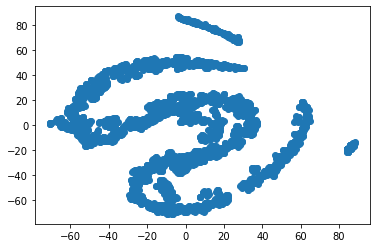

In [ ]:
# Prepare corpus of sentences separed in terms
corpus = []
for t in tweets:
  terms = preprocess(t.tweet)
  corpus.append(terms)

# Create model with word2vec and our corpus of tweets
model = Word2Vec(corpus, workers=4, size=100, min_count=1, window=10, sample=1e-3)
# Vectorize tweets
vectorized_tweets = vectorize_tweets(tweets,model)
X = vectorized_tweets
# Apply TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
# Plot TSNE
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()